In [1]:
from azureml.core import Workspace, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime
import sklearn.metrics as skm
import warnings
warnings.filterwarnings('ignore')

## Siirtymätodennäköisyyksien  analysointia päivätasolla

In [2]:
train_test_day = pd.Timestamp('2018-10-01')
start = pd.Timestamp('2017-01-01T00')
end = pd.Timestamp('2019-12-31T00')

const1 = 1096
const2 = 1095

const3 = 500
const4 = 499

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean(np.power((y_true - y_pred), 2))


In [4]:
def smoothen_transition_probs(df_mean):
    for row in range(len(df_mean)):
        probs_sum = np.sum([df_mean.at[row, n] for n in df_mean.columns])
        for names in df_mean.columns:
            df_mean.loc[df_mean.index == row, names] = df_mean.loc[df_mean.index == row, names] / probs_sum + 0.000000001
    return df_mean

## Lasten Päivystys

In [ ]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='uranus27_1')
features = ['kaynti_numero', 'potilasnumero', 'henkilotunnus', 'alkuhetki', 'loppuhetki',
       'vo_toimipiste_nimi', 'kayntityyppi_selite', 'varaustyyppi_selite',
       'mista_tuli_selite', 'res_koodi', 'res_selite', 'jh_selite', 
       'jatkoh_laitos_nimi', 'jatkoh_toimipiste_nimi']
df = dataset.to_pandas_dataframe()[features]
df.replace("", float("NaN"), inplace=True)
df.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
df.drop_duplicates(subset='kaynti_numero', inplace=True)
df = df[df['varaustyyppi_selite'] != 'PÄIV PKL soitto']
df = df[(df['kayntityyppi_selite'] != 'Hoitokäynti') & (df['kayntityyppi_selite'] != 'Ohjattu muualle') & 
       (df['kayntityyppi_selite'] !='HYKSin Oy:n potilas') & (df['kayntityyppi_selite'] != 'Sarjahoitokäynti') & 
       (df['kayntityyppi_selite'] != 'Ensikäynti')]
df = df[(df.alkuhetki >= start) & (df.alkuhetki < end)]
df_train = df
df_test = df[df.alkuhetki >= train_test_day]
pd.set_option('display.max_columns', None)
df_train = df_train.sort_values(by='alkuhetki')


In [6]:
df_train['alkuhetki'] = pd.to_datetime(df_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train['loppuhetki'] = pd.to_datetime(df_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train = df_train[df_train['alkuhetki'] <= df_train['loppuhetki']]
df_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_train['alkuhetki'], right = df_train['loppuhetki'], closed='neither')
df_train['palveluaika'] = ((df_train['loppuhetki'] - df_train['alkuhetki']).astype('timedelta64[s]') / 3600)

In [7]:
aika = start
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(const1)]}) # 876
timestamp_day = [aika + timedelta(days=x) for x in range(const2)] # 875
df_train_day = pd.DataFrame(data={'time':timestamp_day})
df_train_day['weekday'] = df_train_day['time'].dt.weekday
df_train_day['month'] = df_train_day['time'].dt.month
df_train_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
df_train_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).overlaps(b) for b in df_train['aikaväli']]).sum()

for t in range(len(df_train_day['timespan'])):
    sum = 0
    for a, b in zip(df_train['aikaväli'], df_train['loppuhetki']):
        if ((df_train_day.loc[t, 'timespan'].overlaps(a)) == True) & ((b in df_train_day.loc[t, 'timespan']) == False):
            sum += 1
    df_train_day.loc[t, 'päiv'] = sum
df_train_day['JOL1'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train[df_train.jatkoh_laitos_nimi == 'JOL1'].loppuhetki]).sum()
df_train_day['koti'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train[df_train.jh_selite == 'Koti'].loppuhetki]).sum()
df_train_day['muu'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train[(df_train.jh_selite != 'Koti') & (df_train.jatkoh_laitos_nimi != 'JOL1')].loppuhetki]).sum()
df_train_day.set_index('time', inplace=True)

In [8]:
df_train_day['summa'] = df_train_day.loc[:, ['päiv', 'JOL1', 'koti', 'muu']].sum(axis=1)

In [9]:
df_train_day['päiv_prob'] = df_train_day.päiv / df_train_day.patient_count
df_train_day['JOL1_prob'] = df_train_day.JOL1 / df_train_day.patient_count
df_train_day['koti_prob'] = df_train_day.koti / df_train_day.patient_count
df_train_day['muu_prob'] = df_train_day.muu / df_train_day.patient_count
df_train_day_grouped = df_train_day.groupby(by='weekday')
df_train_mean = df_train_day_grouped.mean()
df_train_mean

,month,patient_count,päiv,JOL1,koti,muu,summa,päiv_prob,JOL1_prob,koti_prob,muu_prob
weekday,,,,,,,,,,,
0,6.528662,72.675159,5.961783,5.152866,56.777070,4.936306,72.828025,0.080352,0.069981,0.785687,0.066099
1,6.477707,68.363057,5.834395,5.063694,52.579618,4.993631,68.471338,0.082164,0.074763,0.772814,0.071913
2,6.474359,67.083333,5.820513,4.519231,52.211538,4.660256,67.211538,0.083467,0.066148,0.784927,0.067386
3,6.506410,66.192308,5.512821,4.461538,51.544872,4.788462,66.307692,0.081133,0.066015,0.782207,0.072349
4,6.544872,67.929487,5.480769,4.294872,53.397436,4.865385,68.038462,0.079034,0.062290,0.789076,0.071213
5,6.576923,89.391026,6.410256,3.929487,74.775641,4.371795,89.487179,0.070414,0.043030,0.840639,0.047008
6,6.573248,95.127389,6.210191,4.305732,80.643312,4.012739,95.171975,0.064929,0.043860,0.850558,0.041142


In [10]:
train_first = df_train_day[df_train_day.index < pd.Timestamp('2018-01-01')].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']]
train_second = df_train_day[(df_train_day.index >= pd.Timestamp('2018-01-01')) & (df_train_day.index < pd.Timestamp('2019-01-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']]
train_third = df_train_day[(df_train_day.index >= pd.Timestamp('2019-01-01')) & (df_train_day.index < pd.Timestamp('2020-01-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']]

In [11]:
train_first = smoothen_transition_probs(train_first)
train_second = smoothen_transition_probs(train_second)
train_third = smoothen_transition_probs(train_third)

In [12]:
monday = pd.concat([train_first.loc[0], train_second.loc[0], train_third.loc[0]], axis=1)

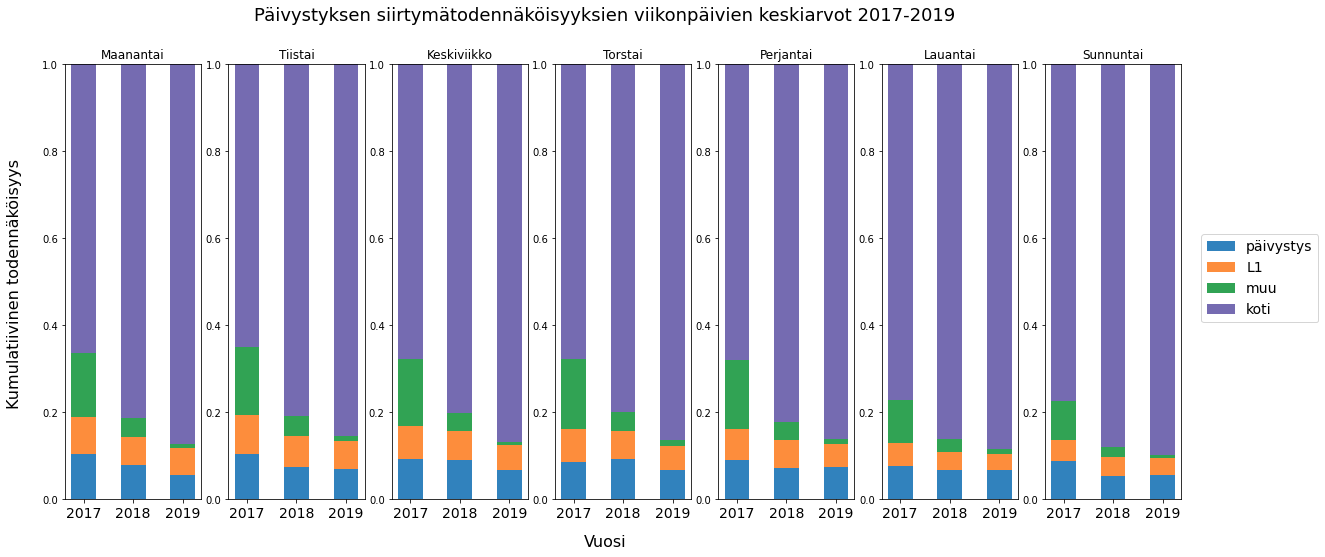

In [13]:
years = (
    "2017",
    "2018",
    "2019"
)
weight_counts = {
    "päiv_prob": monday.loc['päiv_prob'].values,
    "JOL1_prob": monday.loc['JOL1_prob'].values,
    "muu_prob": monday.loc['muu_prob'].values,
    "koti_prob": monday.loc['koti_prob'].values
}
width = 0.5
cmap = plt.get_cmap('tab20c')
rgb_cm = [cmap.colors[0], cmap.colors[5], cmap.colors[8], cmap.colors[12]]
plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 8))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
weekdays = ['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai']

for i in range(7):
    weekday = pd.concat([train_first.loc[i], train_second.loc[i], train_third.loc[i]], axis=1)
    weight_counts = {
    "päiv_prob": weekday.loc['päiv_prob'].values,
    "JOL1_prob": weekday.loc['JOL1_prob'].values,
    "muu_prob": weekday.loc['muu_prob'].values,
    "koti_prob": weekday.loc['koti_prob'].values
    }
    bottom = np.zeros(3)
    c = 0
    for boolean, weight_count in weight_counts.items():
        p = axes[i].bar(years, weight_count, width, label=boolean, bottom=bottom, color=rgb_cm[c])
        bottom += weight_count
        c += 1
    axes[i].set_title(weekdays[i])
    axes[i].margins(y=0)
    axes[i].set_xticklabels(labels=years, fontsize=14)

plt.figlegend(["päivystys", "L1", "muu", "koti"], loc='center right', fontsize=14)
fig.suptitle("Päivystyksen siirtymätodennäköisyyksien viikonpäivien keskiarvot 2017-2019", fontsize=18)
fig.text(0.5, 0.05, 'Vuosi', ha='center', va='center', fontsize=16)
fig.text(0.09, 0.5, 'Kumulatiivinen todennäköisyys', ha='center', va='center', rotation='vertical', fontsize=16)
plt.show()

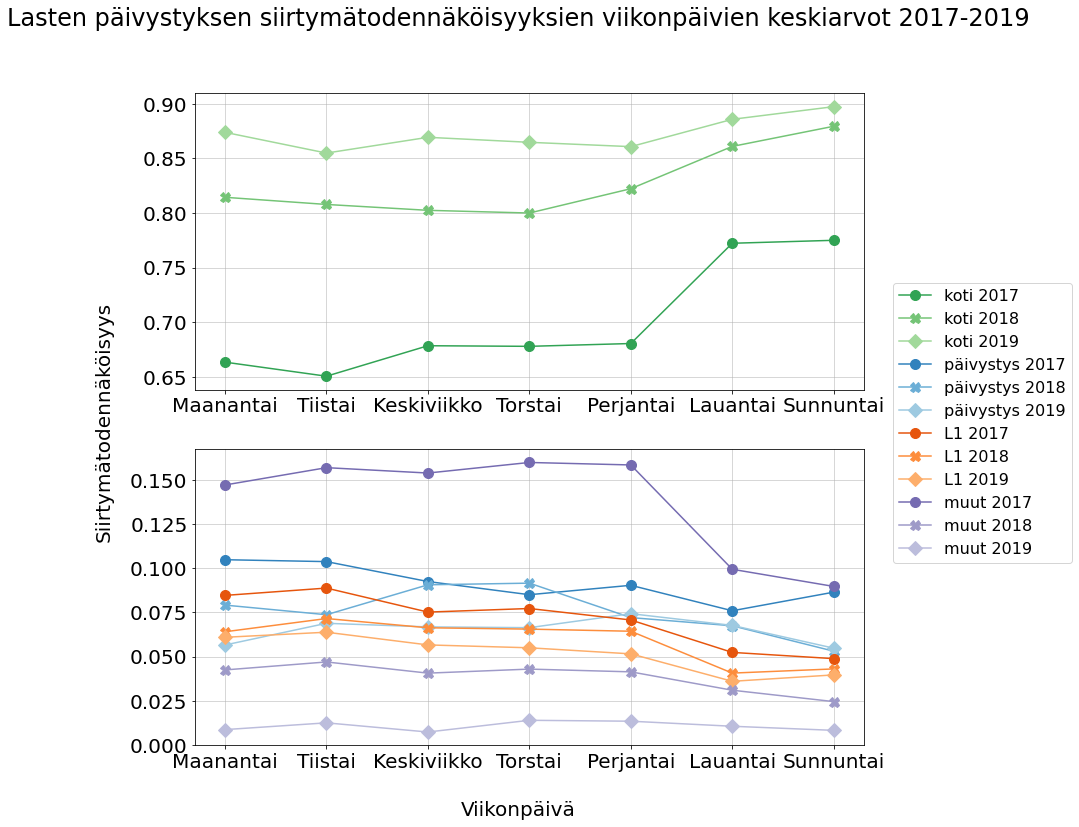

In [14]:
cmap = plt.get_cmap('tab20c')

fc = [cmap.colors[0], cmap.colors[4], cmap.colors[8], cmap.colors[12]]
sc = [cmap.colors[1], cmap.colors[5], cmap.colors[9], cmap.colors[13]]
tc = [cmap.colors[2], cmap.colors[6], cmap.colors[10], cmap.colors[14]]
plt.rcParams.update({'font.size': 20})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

weekdays = ['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai']
for i in range(4):
    if i != 2:
        ax2.plot(train_first.T.iloc[i], '-o', c=fc[i], markersize=10)
        ax2.plot(train_second.T.iloc[i], '-X', c=sc[i], markersize=10)
        ax2.plot(train_third.T.iloc[i], '-D', c=tc[i], markersize=10)
    elif i == 2:
        ax1.plot(train_first.T.iloc[i], '-o', c=fc[i], markersize=10)
        ax1.plot(train_second.T.iloc[i], '-X', c=sc[i], markersize=10)
        ax1.plot(train_third.T.iloc[i], '-D', c=tc[i], markersize=10)

ax1.set_xticks(range(7), labels=weekdays)
ax2.set_xticks(range(7), labels=weekdays)
ax1.grid(linewidth=0.5)
ax2.grid(linewidth=0.5)
plt.figlegend(["koti 2017", "koti 2018", "koti 2019", "päivystys 2017", "päivystys 2018", "päivystys 2019", "L1 2017", 
    "L1 2018", "L1 2019", "muut 2017", "muut 2018", "muut 2019"], bbox_to_anchor=(1.15, 0.67), fontsize=16)
fig.suptitle("Lasten päivystyksen siirtymätodennäköisyyksien viikonpäivien keskiarvot 2017-2019", fontsize=24)
plt.xticks(range(7), labels=weekdays)
fig.text(0.5, 0.05, 'Viikonpäivä', ha='center', va='center', fontsize=20)
fig.text(0.02, 0.5, 'Siirtymätodennäköisyys', ha='center', va='center', rotation='vertical', fontsize=20)
plt.show()

In [15]:
train_first = df_train_day[(df_train_day.index >= pd.Timestamp('2019-01-01')) & (df_train_day.index < pd.Timestamp('2019-05-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']]
train_second = df_train_day[(df_train_day.index >= pd.Timestamp('2019-05-01')) & (df_train_day.index < pd.Timestamp('2019-09-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']]
train_third = df_train_day[(df_train_day.index >= pd.Timestamp('2019-09-01')) & (df_train_day.index < pd.Timestamp('2019-12-31'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']]

In [16]:
train_first = smoothen_transition_probs(train_first)
train_second = smoothen_transition_probs(train_second)
train_third = smoothen_transition_probs(train_third)

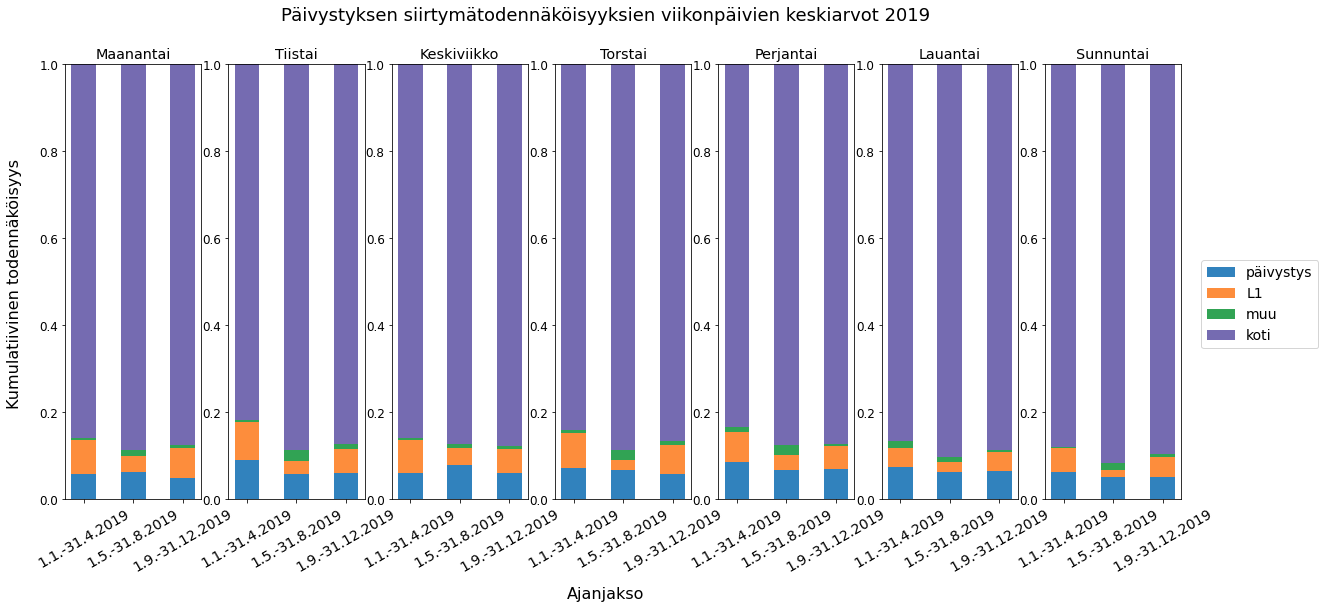

In [17]:
years = (
    "1.1.-31.4.2019",
    "1.5.-31.8.2019",
    "1.9.-31.12.2019"
)

width = 0.5
cmap = plt.get_cmap('tab20c')
rgb_cm = [cmap.colors[0], cmap.colors[5], cmap.colors[8], cmap.colors[12]]
plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 8))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
weekdays = ['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai']

for i in range(7):
    weekday = pd.concat([train_first.loc[i], train_second.loc[i], train_third.loc[i]], axis=1)
    weight_counts = {
    "päiv_prob": weekday.loc['päiv_prob'].values,
    "JOL1_prob": weekday.loc['JOL1_prob'].values,
    "muu_prob": weekday.loc['muu_prob'].values,
    "koti_prob": weekday.loc['koti_prob'].values
    }
    bottom = np.zeros(3)
    c = 0
    for boolean, weight_count in weight_counts.items():
        p = axes[i].bar(years, weight_count, width, label=boolean, bottom=bottom, color=rgb_cm[c])
        bottom += weight_count
        c += 1
    axes[i].set_title(weekdays[i])
    axes[i].margins(y=0)
    axes[i].set_xticklabels(labels=years, rotation=30, fontsize=14)

plt.figlegend(["päivystys", "L1", "muu", "koti"], loc='center right', fontsize=14)
fig.suptitle("Päivystyksen siirtymätodennäköisyyksien viikonpäivien keskiarvot 2019", fontsize=18)
fig.text(0.5, -0.04, 'Ajanjakso', ha='center', va='center', fontsize=16)
fig.text(0.09, 0.5, 'Kumulatiivinen todennäköisyys', ha='center', va='center', rotation='vertical', fontsize=16)
plt.show()

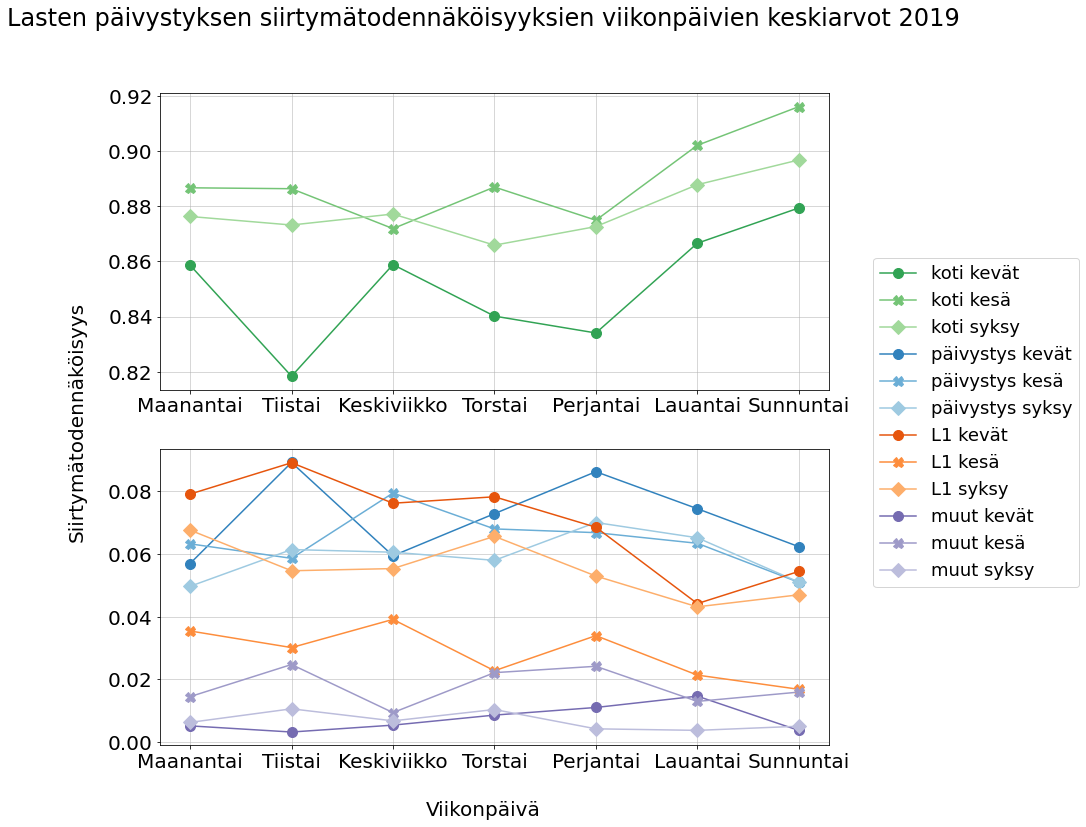

In [18]:
cmap = plt.get_cmap('tab20c')

fc = [cmap.colors[0], cmap.colors[4], cmap.colors[8], cmap.colors[12]]
sc = [cmap.colors[1], cmap.colors[5], cmap.colors[9], cmap.colors[13]]
tc = [cmap.colors[2], cmap.colors[6], cmap.colors[10], cmap.colors[14]]
plt.rcParams.update({'font.size': 20})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

weekdays = ['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai']
for i in range(4):
    if i != 2:
        ax2.plot(train_first.T.iloc[i], '-o', c=fc[i], markersize=10)
        ax2.plot(train_second.T.iloc[i], '-X', c=sc[i], markersize=10)
        ax2.plot(train_third.T.iloc[i], '-D', c=tc[i], markersize=10)
    elif i == 2:
        ax1.plot(train_first.T.iloc[i], '-o', c=fc[i], markersize=10)
        ax1.plot(train_second.T.iloc[i], '-X', c=sc[i], markersize=10)
        ax1.plot(train_third.T.iloc[i], '-D', c=tc[i], markersize=10)

ax1.set_xticks(range(7), labels=weekdays)
ax2.set_xticks(range(7), labels=weekdays)
ax1.grid(linewidth=0.5)
ax2.grid(linewidth=0.5)
plt.figlegend(["koti kevät", "koti kesä", "koti syksy", "päivystys kevät", "päivystys kesä", "päivystys syksy", 
    "L1 kevät", "L1 kesä", "L1 syksy", "muut kevät", "muut kesä", "muut syksy"], bbox_to_anchor=(1.2, 0.7), fontsize=18)
fig.suptitle("Lasten päivystyksen siirtymätodennäköisyyksien viikonpäivien keskiarvot 2019", fontsize=24)
plt.xticks(range(7), labels=weekdays)
fig.text(0.5, 0.05, 'Viikonpäivä', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, 'Siirtymätodennäköisyys', ha='center', va='center', rotation='vertical', fontsize=20)
plt.grid(linewidth=0.5)
plt.show()

## Lasten päivystyksen testidata

In [19]:
df_test['alkuhetki'] = pd.to_datetime(df_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test['loppuhetki'] = pd.to_datetime(df_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test = df_test[df_test['alkuhetki'] <= df_test['loppuhetki']]
df_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_test['alkuhetki'], right = df_test['loppuhetki'], closed='neither')
df_test['palveluaika'] = ((df_test['loppuhetki'] - df_test['alkuhetki']).astype('timedelta64[s]') / 3600)

In [20]:
aika = train_test_day
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(const3)]})
timestamp_day = [aika + timedelta(days=x) for x in range(const4)]
df_test_day = pd.DataFrame(data={'time':timestamp_day})
df_test_day['weekday'] = df_test_day['time'].dt.weekday
df_test_day['month'] = df_test_day['time'].dt.month
df_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
df_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_day['timespan']).overlaps(b) for b in df_test['aikaväli']]).sum()

for t in range(len(df_test_day['timespan'])):
    sum = 0
    for a, b in zip(df_test['aikaväli'], df_test['loppuhetki']):
        if ((df_test_day.loc[t, 'timespan'].overlaps(a)) == True) & ((b in df_test_day.loc[t, 'timespan']) == False):
            sum += 1
    df_test_day.loc[t, 'päiv'] = sum
df_test_day['JOL1'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_day['timespan']).contains(b) for b in df_test[df_test.jatkoh_laitos_nimi == 'JOL1'].loppuhetki]).sum()
df_test_day['koti'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_day['timespan']).contains(b) for b in df_test[df_test.jh_selite == 'Koti'].loppuhetki]).sum()
df_test_day['muu'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_day['timespan']).contains(b) for b in df_test[(df_test.jh_selite != 'Koti') & (df_test.jatkoh_laitos_nimi != 'JOL1')].loppuhetki]).sum()
df_test_day.set_index('time', inplace=True)

In [21]:
df_test_day['päiv_prob'] = df_test_day.päiv / df_test_day.patient_count
df_test_day['JOL1_prob'] = df_test_day.JOL1 / df_test_day.patient_count
df_test_day['koti_prob'] = df_test_day.koti / df_test_day.patient_count
df_test_day['muu_prob'] = df_test_day.muu / df_test_day.patient_count
df_test_mean = df_test_day.groupby(by='weekday').mean()
df_test_mean

,month,patient_count,päiv,JOL1,koti,muu,päiv_prob,JOL1_prob,koti_prob,muu_prob
weekday,,,,,,,,,,
0,7.027778,62.916667,3.416667,4.152778,55.041667,0.388889,0.054548,0.063335,0.876346,0.007039
1,6.888889,57.861111,3.847222,3.736111,49.805556,0.541667,0.064479,0.067028,0.859104,0.010649
2,6.816901,59.112676,4.014085,3.746479,51.056338,0.436620,0.066429,0.061134,0.867043,0.007770
3,6.845070,58.901408,4.084507,3.450704,50.802817,0.633803,0.068619,0.056679,0.864176,0.011899
4,6.887324,58.802817,4.295775,3.338028,50.661972,0.591549,0.071589,0.055307,0.863247,0.011250
5,6.929577,78.197183,5.295775,2.943662,69.281690,0.760563,0.067273,0.036534,0.887615,0.009686
6,6.957746,83.338028,4.774648,3.690141,74.366197,0.535211,0.055756,0.042095,0.895238,0.007237


### Historiadataan pohjautuvien ja toteutuneiden siirtymätodennäköisyyksien erot

In [50]:
test_first = smoothen_transition_probs(df_test_day[df_test_day.index < pd.Timestamp('2019-01-01')].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
test_second = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2018-11-01')) & (df_test_day.index < pd.Timestamp('2019-01-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
test_third = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2018-12-01')) & (df_test_day.index < pd.Timestamp('2019-01-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
test_true = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2019-01-22')) & (df_test_day.index < pd.Timestamp('2019-02-12'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
mape1 = mean_absolute_percentage_error(test_true, test_first)
mae1 = mean_absolute_error(test_true, test_first)
mse1 = mean_squared_error(test_true, test_first)
rmse1 = np.sqrt(mse1)

mape2 = mean_absolute_percentage_error(test_true, test_second)
mae2 = mean_absolute_error(test_true, test_second)
mse2 = mean_squared_error(test_true, test_second)
rmse2 = np.sqrt(mse2)

mape3 = mean_absolute_percentage_error(test_true, test_third)
mae3 = mean_absolute_error(test_true, test_third)
mse3 = mean_squared_error(test_true, test_third)
rmse3 = np.sqrt(mse3)


test_first = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2018-12-01')) & (df_test_day.index < pd.Timestamp('2019-03-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
test_second = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2019-01-01')) & (df_test_day.index < pd.Timestamp('2019-03-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
test_third = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2019-02-01')) & (df_test_day.index < pd.Timestamp('2019-03-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
test_true = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2019-03-22')) & (df_test_day.index < pd.Timestamp('2019-04-12'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
mape4 = mean_absolute_percentage_error(test_true, test_first)
mae4 = mean_absolute_error(test_true, test_first)
mse4 = mean_squared_error(test_true, test_first)
rmse4 = np.sqrt(mse4)

mape5 = mean_absolute_percentage_error(test_true, test_second)
mae5 = mean_absolute_error(test_true, test_second)
mse5 = mean_squared_error(test_true, test_second)
rmse5 = np.sqrt(mse5)

mape6 = mean_absolute_percentage_error(test_true, test_third)
mae6 = mean_absolute_error(test_true, test_third)
mse6 = mean_squared_error(test_true, test_third)
rmse6 = np.sqrt(mse6)


test_first = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2019-08-01')) & (df_test_day.index < pd.Timestamp('2019-11-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
test_second = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2019-09-01')) & (df_test_day.index < pd.Timestamp('2019-11-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
test_third = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2019-10-01')) & (df_test_day.index < pd.Timestamp('2019-11-01'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
test_true = smoothen_transition_probs(df_test_day[(df_test_day.index >= pd.Timestamp('2019-11-22')) & (df_test_day.index < pd.Timestamp('2019-12-13'))].groupby(by='weekday').mean()[['päiv_prob', 'JOL1_prob', 'koti_prob', 'muu_prob']])
mape7 = mean_absolute_percentage_error(test_true, test_first)
mae7 = mean_absolute_error(test_true, test_first)
mse7 = mean_squared_error(test_true, test_first)
rmse7 = np.sqrt(mse7)

mape8 = mean_absolute_percentage_error(test_true, test_second)
mae8 = mean_absolute_error(test_true, test_second)
mse8 = mean_squared_error(test_true, test_second)
rmse8 = np.sqrt(mse8)

mape9 = mean_absolute_percentage_error(test_true, test_third)
mae9 = mean_absolute_error(test_true, test_third)
mse9 = mean_squared_error(test_true, test_third)
rmse9 = np.sqrt(mse9)

In [ ]:
# Yksikkökohtaisten siirtymätodennäköisyyksien virheet
print('MAPE:', mape1)
print('MAE:', mae1)
print('MSE:', mse1)
print('RMSE:', rmse1)

print('MAPE:', mape2)
print('MAE:', mae2)
print('MSE:', mse2)
print('RMSE:', rmse2)

print('MAPE:', mape3)
print('MAE:', mae3)
print('MSE:', mse3)
print('RMSE:', rmse3)

print('MAPE:', mape4)
print('MAE:', mae4)
print('MSE:', mse4)
print('RMSE:', rmse4)

print('MAPE:', mape5)
print('MAE:', mae5)
print('MSE:', mse5)
print('RMSE:', rmse5)

print('MAPE:', mape6)
print('MAE:', mae6)
print('MSE:', mse6)
print('RMSE:', rmse6)

print('MAPE:', mape7)
print('MAE:', mae7)
print('MSE:', mse7)
print('RMSE:', rmse7)

print('MAPE:', mape8)
print('MAE:', mae8)
print('MSE:', mse8)
print('RMSE:', rmse8)

print('MAPE:', mape9)
print('MAE:', mae9)
print('MSE:', mse9)
print('RMSE:', rmse9)


In [52]:
print('MAPE 1st time period, 3 months:', mape1[['päiv_prob', 'JOL1_prob', 'koti_prob']].mean())
print('MAE 1st time period, 3 months:', mae1.mean())
print('MSE 1st time period, 3 months:', mse1.mean())
print('RMSE 1st time period, 3 months:', rmse1.mean())

print('MAPE 1st time period, 2 months:', mape2[['päiv_prob', 'JOL1_prob', 'koti_prob']].mean())
print('MAE 1st time period, 2 months:', mae2.mean())
print('MSE 1st time period, 2 months:', mse2.mean())
print('RMSE 1st time period, 2 months:', rmse2.mean())

print('MAPE 1st time period, 1 months:', mape3[['päiv_prob', 'JOL1_prob', 'koti_prob']].mean())
print('MAE 1st time period, 1 months:', mae3.mean())
print('MSE 1st time period, 1 months:', mse3.mean())
print('RMSE 1st time period, 1 months:', rmse3.mean())

print('MAPE 2nd time period, 3 months:', mape4[['päiv_prob', 'JOL1_prob', 'koti_prob']].mean())
print('MAE 2nd time period, 3 months:', mae4.mean())
print('MSE 2nd time period, 3 months:', mse4.mean())
print('RMSE 2nd time period, 3 months:', rmse4.mean())

print('MAPE 2nd time period, 2 months:', mape5[['päiv_prob', 'JOL1_prob', 'koti_prob']].mean())
print('MAE 2nd time period, 2 months:', mae5.mean())
print('MSE 2nd time period, 2 months:', mse5.mean())
print('RMSE 2nd time period, 2 months:', rmse5.mean())

print('MAPE 2nd time period, 1 months:', mape6[['päiv_prob', 'JOL1_prob', 'koti_prob']].mean())
print('MAE 2nd time period, 1 months:', mae6.mean())
print('MSE 2nd time period, 1 months:', mse6.mean())
print('RMSE 2nd time period, 1 months:', rmse6.mean())

print('MAPE 3rd time period, 3 months:', mape7[['päiv_prob', 'JOL1_prob', 'koti_prob']].mean())
print('MAE 3rd time period, 3 months:', mae7.mean())
print('MSE 3rd time period, 3 months:', mse7.mean())
print('RMSE 3rd time period, 3 months:', rmse7.mean())

print('MAPE 3rd time period, 2 months:', mape8[['päiv_prob', 'JOL1_prob', 'koti_prob']].mean())
print('MAE 3rd time period, 2 months:', mae8.mean())
print('MSE 3rd time period, 2 months:', mse8.mean())
print('RMSE 3rd time period, 2 months:', rmse8.mean())

print('MAPE 3rd time period, 1 months:', mape9[['päiv_prob', 'JOL1_prob', 'koti_prob']].mean())
print('MAE 3rd time period, 1 months:', mae9.mean())
print('MSE 3rd time period, 1 months:', mse9.mean())
print('RMSE 3rd time period, 1 months:', rmse9.mean())

MAPE 1st time period, 3 months: 15.636974016268736
MAE 1st time period, 3 months: 0.020152455622053866
MSE 1st time period, 3 months: 0.0007263015372659424
RMSE 1st time period, 3 months: 0.023805009349287337
MAPE 1st time period, 2 months: 13.481683604851453
MAE 1st time period, 2 months: 0.01703568920263101
MSE 1st time period, 2 months: 0.0005752365473168364
RMSE 1st time period, 2 months: 0.020844264187022028
MAPE 1st time period, 1 months: 14.159741041690312
MAE 1st time period, 1 months: 0.016976643014571465
MSE 1st time period, 1 months: 0.0005207814733368416
RMSE 1st time period, 1 months: 0.020772116326887902
MAPE 2nd time period, 3 months: 21.93729801912542
MAE 2nd time period, 3 months: 0.016243700357154858
MSE 2nd time period, 3 months: 0.0003844019124408965
RMSE 2nd time period, 3 months: 0.017484532052666188
MAPE 2nd time period, 2 months: 24.643735075846823
MAE 2nd time period, 2 months: 0.018690650978048753
MSE 2nd time period, 2 months: 0.0005301126339222298
RMSE 2nd t

## L1-osasto

In [ ]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset_ward = Dataset.get_by_name(workspace, name='uranus27_2')
features_ward = ['henkilotunnus', 'alkuhetki', 'loppuhetki', 'vo_toimipiste_nimi', 'pot_eala_selite', 
       'paadg_oire_selite', 'mista_lah_tuli_koodi', 'mista_lah_tuli_nimi', 'mista_tuli_koodi', 'mista_tuli_selite', 
       'jatkoh_laitos_nimi', 'jatkoh_toimipiste_nimi', 'jh_koodi', 'jh_selite', 'osastohoito_numero', 'shjakso_numero']
ward = dataset_ward.to_pandas_dataframe()[features_ward]
ward.replace("", float("NaN"), inplace=True)
ward.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
ward.drop_duplicates(subset='osastohoito_numero', inplace=True)
ward = ward[(ward.alkuhetki >= start) & (ward.alkuhetki < end)]
ward_train = ward
ward_test = ward[ward.alkuhetki >= train_test_day]

In [29]:
ward_train['alkuhetki'] = pd.to_datetime(ward_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train['loppuhetki'] = pd.to_datetime(ward_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train = ward_train[ward_train['alkuhetki'] <= ward_train['loppuhetki']]
ward_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_train['alkuhetki'], right = ward_train['loppuhetki'], closed='neither')
ward_train['palveluaika'] = np.round(((ward_train['loppuhetki'] - ward_train['alkuhetki']).astype('timedelta64[s]') / 3600 / 24))
ward_train['alku'] = ward_train.alkuhetki
ward_train['loppu'] = ward_train.loppuhetki
ward_train.reset_index(drop=True, inplace=True)

In [30]:
aika = start
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(const1)]})
timestamp_day = [aika + timedelta(days=x) for x in range(const2)]
ward_train_day = pd.DataFrame(data={'time':timestamp_day})
ward_train_day['weekday'] = ward_train_day['time'].dt.weekday
ward_train_day['month'] = ward_train_day['time'].dt.month
ward_train_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
ward_train_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).overlaps(b) for b in ward_train['aikaväli']]).sum()

for t in range(len(ward_train_day['timespan'])):
    sum = 0
    for a, b in zip(ward_train['aikaväli'], ward_train['loppuhetki']):
        if ((ward_train_day.loc[t, 'timespan'].overlaps(a)) == True) & ((b in ward_train_day.loc[t, 'timespan']) == False):
            sum += 1
    ward_train_day.loc[t, 'JOL1'] = sum
ward_train_day['koti'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).contains(b) for b in ward_train[(ward_train.jh_selite == 'Koti')].loppuhetki]).sum()
ward_train_day['muu'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).contains(b) for b in ward_train[(ward_train.jh_selite != 'Koti')].loppuhetki]).sum()
ward_train_day['summa'] = ward_train_day[['JOL1', 'koti', 'muu']].sum()
ward_train_day.set_index('time', inplace=True)

In [31]:
ward_train_day['JOL1_prob'] = ward_train_day.JOL1 / ward_train_day.patient_count
ward_train_day['koti_prob'] = ward_train_day.koti / ward_train_day.patient_count
ward_train_day['muu_prob'] = ward_train_day.muu / ward_train_day.patient_count
ward_train_mean = ward_train_day.groupby(by='weekday').mean()
ward_train_mean

,month,patient_count,JOL1,koti,muu,summa,JOL1_prob,koti_prob,muu_prob
weekday,,,,,,,,,
0,6.528662,18.566879,13.458599,4.261146,0.847134,NaN,0.725343,0.234207,0.040449
1,6.477707,19.579618,13.732484,4.840764,1.006369,NaN,0.702543,0.252363,0.045094
2,6.474359,19.153846,13.608974,4.557692,0.987179,NaN,0.709454,0.241564,0.048981
3,6.506410,18.980769,13.487179,4.480769,1.012821,NaN,0.711865,0.239432,0.048703
4,6.544872,18.467949,12.602564,4.955128,0.910256,NaN,0.681001,0.274073,0.044926
5,6.576923,17.006410,12.064103,4.173077,0.769231,NaN,0.712882,0.246493,0.040626
6,6.573248,16.866242,12.254777,3.987261,0.624204,NaN,0.724208,0.241575,0.034218


In [32]:
ward_train_first = ward_train_day[ward_train_day.index < pd.Timestamp('2018-01-01')].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']]
ward_train_second = ward_train_day[(ward_train_day.index >= pd.Timestamp('2018-01-01')) & (ward_train_day.index < pd.Timestamp('2019-01-01'))].groupby(by='weekday').mean()[[ 'JOL1_prob', 'koti_prob', 'muu_prob']]
ward_train_third = ward_train_day[(ward_train_day.index >= pd.Timestamp('2019-01-01')) & (ward_train_day.index < pd.Timestamp('2020-01-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']]

In [33]:
ward_train_first = smoothen_transition_probs(ward_train_first)
ward_train_second = smoothen_transition_probs(ward_train_second)
ward_train_third = smoothen_transition_probs(ward_train_third)

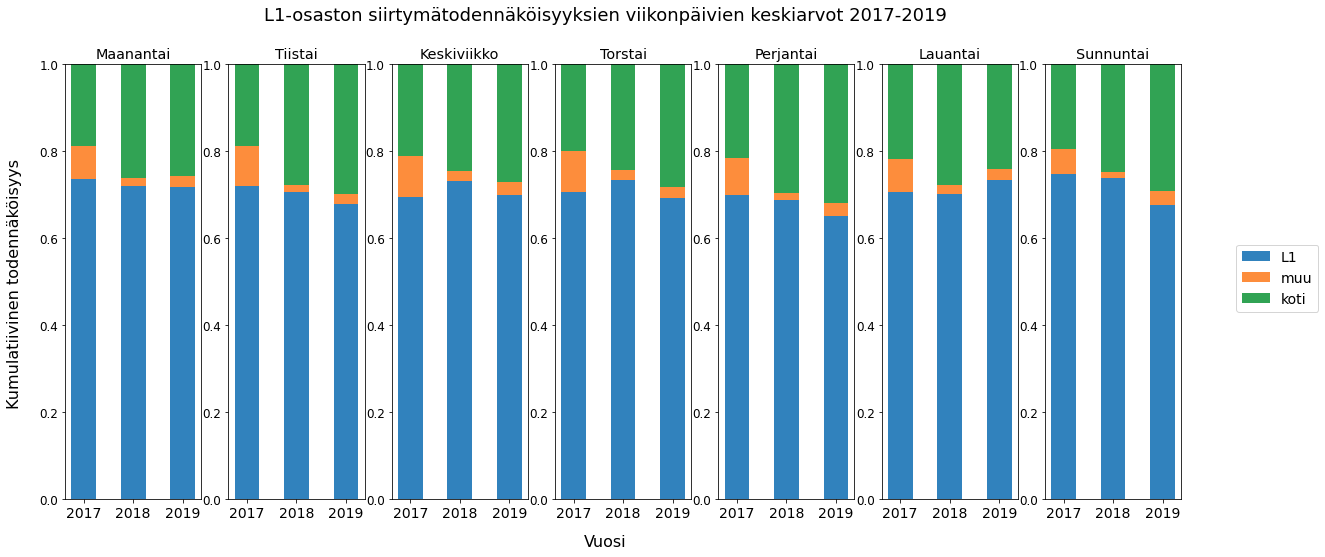

In [35]:
years = (
    "2017",
    "2018",
    "2019"
)

width = 0.5
cmap = plt.get_cmap('tab20c')
rgb_cm = [cmap.colors[0], cmap.colors[5], cmap.colors[8], cmap.colors[12]]
plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 8))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
weekdays = ['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai']

for i in range(7):
    weekday = pd.concat([ward_train_first.loc[i], ward_train_second.loc[i], ward_train_third.loc[i]], axis=1)
    weight_counts = {
    "JOL1_prob": weekday.loc['JOL1_prob'].values,
    "muu_prob": weekday.loc['muu_prob'].values,
    "koti_prob": weekday.loc['koti_prob'].values
    }
    bottom = np.zeros(3)
    c = 0
    for boolean, weight_count in weight_counts.items():
        p = axes[i].bar(years, weight_count, width, label=boolean, bottom=bottom, color=rgb_cm[c]) #, color=rgb_cm
        bottom += weight_count
        c += 1
    axes[i].set_title(weekdays[i])
    axes[i].margins(y=0)
    axes[i].set_xticklabels(labels=years, fontsize=14)

plt.figlegend([ "L1", "muu", "koti"], loc='center right', fontsize=14)
fig.suptitle("L1-osaston siirtymätodennäköisyyksien viikonpäivien keskiarvot 2017-2019", fontsize=18)
fig.text(0.5, 0.05, 'Vuosi', ha='center', va='center', fontsize=16)
fig.text(0.09, 0.5, 'Kumulatiivinen todennäköisyys', ha='center', va='center', rotation='vertical', fontsize=16)
plt.show()

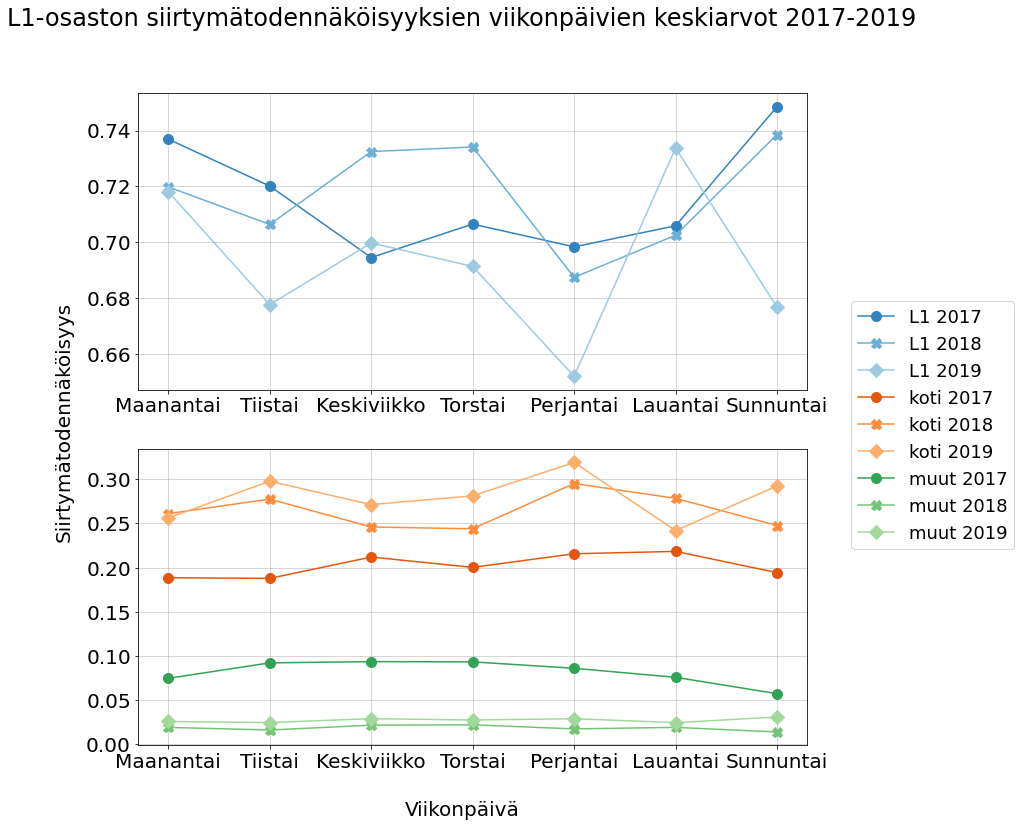

In [36]:
cmap = plt.get_cmap('tab20c')

fc = [cmap.colors[0], cmap.colors[4], cmap.colors[8], cmap.colors[12]]
sc = [cmap.colors[1], cmap.colors[5], cmap.colors[9], cmap.colors[13]]
tc = [cmap.colors[2], cmap.colors[6], cmap.colors[10], cmap.colors[14]]
plt.rcParams.update({'font.size': 20})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

weekdays = ['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai']
for i in range(3):
    if i != 0:
        ax2.plot(ward_train_first.T.iloc[i], '-o', c=fc[i], markersize=10)
        ax2.plot(ward_train_second.T.iloc[i], '-X', c=sc[i], markersize=10)
        ax2.plot(ward_train_third.T.iloc[i], '-D', c=tc[i], markersize=10)
    elif i == 0:
        ax1.plot(ward_train_first.T.iloc[i], '-o', c=fc[i], markersize=10)
        ax1.plot(ward_train_second.T.iloc[i], '-X', c=sc[i], markersize=10)
        ax1.plot(ward_train_third.T.iloc[i], '-D', c=tc[i], markersize=10)

ax1.set_xticks(range(7), labels=weekdays)
ax2.set_xticks(range(7), labels=weekdays)
ax1.grid(linewidth=0.5)
ax2.grid(linewidth=0.5)
plt.figlegend(["L1 2017", "L1 2018", "L1 2019", "koti 2017", "koti 2018", "koti 2019", "muut 2017", "muut 2018", "muut 2019"],
    bbox_to_anchor=(1.15, 0.65), fontsize=18)
fig.suptitle("L1-osaston siirtymätodennäköisyyksien viikonpäivien keskiarvot 2017-2019", fontsize=24)
plt.xticks(range(7), labels=weekdays)
fig.text(0.5, 0.05, 'Viikonpäivä', ha='center', va='center', fontsize=20)
fig.text(0.04, 0.5, 'Siirtymätodennäköisyys', ha='center', va='center', rotation='vertical', fontsize=20)
plt.show()

In [37]:
ward_train_first = ward_train_day[(ward_train_day.index >= pd.Timestamp('2019-01-01')) & (ward_train_day.index < pd.Timestamp('2019-05-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']]
ward_train_second = ward_train_day[(ward_train_day.index >= pd.Timestamp('2019-05-01')) & (ward_train_day.index <= pd.Timestamp('2019-06-18'))].groupby(by='weekday').mean()[[ 'JOL1_prob', 'koti_prob', 'muu_prob']]
ward_train_third = ward_train_day[(ward_train_day.index >= pd.Timestamp('2019-08-21')) & (ward_train_day.index < pd.Timestamp('2020-01-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']]

In [38]:
ward_train_first = smoothen_transition_probs(ward_train_first)
ward_train_second = smoothen_transition_probs(ward_train_second)
ward_train_third = smoothen_transition_probs(ward_train_third)

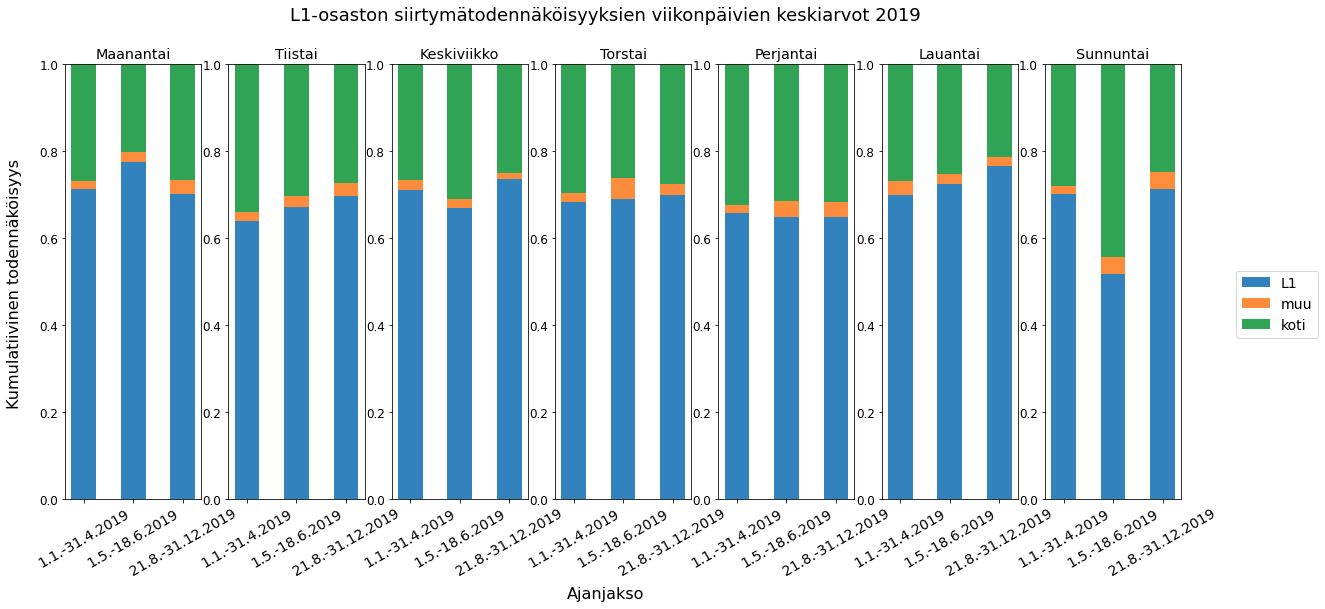

In [39]:
years = (
    "1.1.-31.4.2019",
    "1.5.-18.6.2019",
    "21.8.-31.12.2019"
)

width = 0.5
cmap = plt.get_cmap('tab20c')
rgb_cm = [cmap.colors[0], cmap.colors[5], cmap.colors[8], cmap.colors[12]]
plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 8))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
weekdays = ['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai']

for i in range(7):
    weekday = pd.concat([ward_train_first.loc[i], ward_train_second.loc[i], ward_train_third.loc[i]], axis=1)
    weight_counts = {
    "JOL1_prob": weekday.loc['JOL1_prob'].values,
    "muu_prob": weekday.loc['muu_prob'].values,
    "koti_prob": weekday.loc['koti_prob'].values
    }
    bottom = np.zeros(3)
    c = 0
    for boolean, weight_count in weight_counts.items():
        p = axes[i].bar(years, weight_count, width, label=boolean, bottom=bottom, color=rgb_cm[c])
        bottom += weight_count
        c += 1
    axes[i].set_title(weekdays[i])
    axes[i].margins(y=0)
    axes[i].set_xticklabels(labels=years, rotation=30, fontsize=14)

plt.figlegend(["L1", "muu", "koti"], loc='center right', fontsize=14)
fig.suptitle("L1-osaston siirtymätodennäköisyyksien viikonpäivien keskiarvot 2019", fontsize=18)
fig.text(0.5, -0.04, 'Ajanjakso', ha='center', va='center', fontsize=16)
fig.text(0.09, 0.5, 'Kumulatiivinen todennäköisyys', ha='center', va='center', rotation='vertical', fontsize=16)
plt.show()

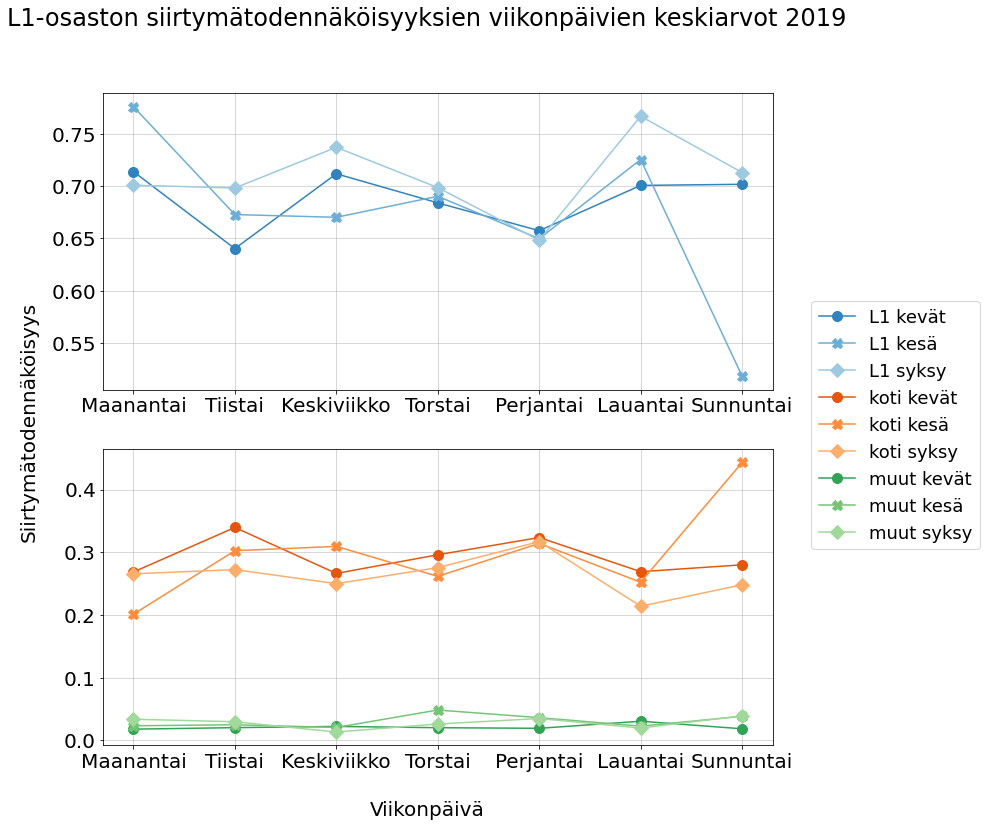

In [40]:
cmap = plt.get_cmap('tab20c')

fc = [cmap.colors[0], cmap.colors[4], cmap.colors[8], cmap.colors[12]]
sc = [cmap.colors[1], cmap.colors[5], cmap.colors[9], cmap.colors[13]]
tc = [cmap.colors[2], cmap.colors[6], cmap.colors[10], cmap.colors[14]]
plt.rcParams.update({'font.size': 20})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

weekdays = ['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai']
for i in range(3):
    if i != 0:
        ax2.plot(ward_train_first.T.iloc[i], '-o', c=fc[i], markersize=10)
        ax2.plot(ward_train_second.T.iloc[i], '-X', c=sc[i], markersize=10)
        ax2.plot(ward_train_third.T.iloc[i], '-D', c=tc[i], markersize=10)
    elif i == 0:
        ax1.plot(ward_train_first.T.iloc[i], '-o', c=fc[i], markersize=10)
        ax1.plot(ward_train_second.T.iloc[i], '-X', c=sc[i], markersize=10)
        ax1.plot(ward_train_third.T.iloc[i], '-D', c=tc[i], markersize=10)

ax1.set_xticks(range(7), labels=weekdays)
ax2.set_xticks(range(7), labels=weekdays)
ax1.grid(linewidth=0.5)
ax2.grid(linewidth=0.5)
plt.figlegend(["L1 kevät", "L1 kesä", "L1 syksy", "koti kevät", "koti kesä", "koti syksy", "muut kevät", "muut kesä", "muut syksy"],
    bbox_to_anchor=(1.15, 0.65), fontsize=18)
fig.suptitle("L1-osaston siirtymätodennäköisyyksien viikonpäivien keskiarvot 2019", fontsize=24)
plt.xticks(range(7), labels=weekdays)
fig.text(0.5, 0.05, 'Viikonpäivä', ha='center', va='center', fontsize=20)
fig.text(0.04, 0.5, 'Siirtymätodennäköisyys', ha='center', va='center', rotation='vertical', fontsize=20)
plt.show()

## L1-osaston testidata

In [41]:
ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test = ward_test[ward_test['alkuhetki'] <= ward_test['loppuhetki']]
ward_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_test['alkuhetki'], right = ward_test['loppuhetki'], closed='neither')
ward_test['palveluaika'] = np.round(((ward_test['loppuhetki'] - ward_test['alkuhetki']).astype('timedelta64[s]') / 3600 / 24))
ward_test['alku'] = ward_test.alkuhetki
ward_test['loppu'] = ward_test.loppuhetki
ward_test.reset_index(drop=True, inplace=True)

In [42]:
aika = train_test_day
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(const3)]}) 
timestamp_day = [aika + timedelta(days=x) for x in range(const4)] 
ward_test_day = pd.DataFrame(data={'time':timestamp_day})
ward_test_day['weekday'] = ward_test_day['time'].dt.weekday
ward_test_day['month'] = ward_test_day['time'].dt.month
ward_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
ward_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_day['timespan']).overlaps(b) for b in ward_test['aikaväli']]).sum()

for t in range(len(ward_test_day['timespan'])):
    sum = 0
    for a, b in zip(ward_test['aikaväli'], ward_test['loppuhetki']):
        if ((ward_test_day.loc[t, 'timespan'].overlaps(a)) == True) & ((b in ward_test_day.loc[t, 'timespan']) == False):
            sum += 1
    ward_test_day.loc[t, 'JOL1'] = sum
ward_test_day['koti'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_day['timespan']).contains(b) for b in ward_test[(ward_test.jh_selite == 'Koti')].loppuhetki]).sum()
ward_test_day['muu'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_day['timespan']).contains(b) for b in ward_test[(ward_test.jh_selite != 'Koti')].loppuhetki]).sum()
ward_test_day.set_index('time', inplace=True)

In [43]:
ward_test_day['JOL1_prob'] = ward_test_day.JOL1 / ward_test_day.patient_count
ward_test_day['koti_prob'] = ward_test_day.koti / ward_test_day.patient_count
ward_test_day['muu_prob'] = ward_test_day.muu / ward_test_day.patient_count
ward_test_day_grouped = ward_test_day.groupby(by='weekday')
ward_test_mean = ward_test_day_grouped.mean()
ward_test_mean

,month,patient_count,JOL1,koti,muu,JOL1_prob,koti_prob,muu_prob
weekday,,,,,,,,
0,7.027778,13.875000,9.972222,3.583333,0.319444,0.734807,0.244747,0.020446
1,6.888889,14.472222,9.763889,4.375000,0.333333,0.694907,0.283969,0.021124
2,6.816901,14.464789,10.225352,3.943662,0.295775,0.712230,0.264987,0.022784
3,6.845070,14.408451,10.014085,4.000000,0.394366,0.688480,0.267422,0.044098
4,6.887324,13.901408,9.014085,4.521127,0.366197,0.647996,0.324874,0.027130
5,6.929577,12.281690,8.732394,3.225352,0.323944,0.726201,0.251135,0.022664
6,6.957746,12.901408,8.816901,3.760563,0.323944,0.691198,0.282352,0.026450


In [46]:
test_first = smoothen_transition_probs(ward_test_day[ward_test_day.index < pd.Timestamp('2019-01-01')].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
test_second = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2018-11-01')) & (ward_test_day.index < pd.Timestamp('2019-01-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
test_third = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2018-12-01')) & (ward_test_day.index < pd.Timestamp('2019-01-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
test_true = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2019-01-22')) & (ward_test_day.index < pd.Timestamp('2019-02-12'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
mape1 = mean_absolute_percentage_error(test_true, test_first)
mae1 = mean_absolute_error(test_true, test_first)
mse1 = mean_squared_error(test_true, test_first)
rmse1 = np.sqrt(mse1)

mape2 = mean_absolute_percentage_error(test_true, test_second)
mae2 = mean_absolute_error(test_true, test_second)
mse2 = mean_squared_error(test_true, test_second)
rmse2 = np.sqrt(mse2)

mape3 = mean_absolute_percentage_error(test_true, test_third)
mae3 = mean_absolute_error(test_true, test_third)
mse3 = mean_squared_error(test_true, test_third)
rmse3 = np.sqrt(mse3)


test_first = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2018-12-01')) & (ward_test_day.index < pd.Timestamp('2019-03-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
test_second = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2019-01-01')) & (ward_test_day.index < pd.Timestamp('2019-03-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
test_third = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2019-02-01')) & (ward_test_day.index < pd.Timestamp('2019-03-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
test_true = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2019-03-22')) & (ward_test_day.index < pd.Timestamp('2019-04-12'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
mape4 = mean_absolute_percentage_error(test_true, test_first)
mae4 = mean_absolute_error(test_true, test_first)
mse4 = mean_squared_error(test_true, test_first)
rmse4 = np.sqrt(mse4)

mape5 = mean_absolute_percentage_error(test_true, test_second)
mae5 = mean_absolute_error(test_true, test_second)
mse5 = mean_squared_error(test_true, test_second)
rmse5 = np.sqrt(mse5)

mape6 = mean_absolute_percentage_error(test_true, test_third)
mae6 = mean_absolute_error(test_true, test_third)
mse6 = mean_squared_error(test_true, test_third)
rmse6 = np.sqrt(mse6)


test_first = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2019-08-01')) & (ward_test_day.index < pd.Timestamp('2019-11-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
test_second = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2019-09-01')) & (ward_test_day.index < pd.Timestamp('2019-11-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
test_third = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2019-10-01')) & (ward_test_day.index < pd.Timestamp('2019-11-01'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
test_true = smoothen_transition_probs(ward_test_day[(ward_test_day.index >= pd.Timestamp('2019-11-22')) & (ward_test_day.index < pd.Timestamp('2019-12-13'))].groupby(by='weekday').mean()[['JOL1_prob', 'koti_prob', 'muu_prob']])
mape7 = mean_absolute_percentage_error(test_true, test_first)
mae7 = mean_absolute_error(test_true, test_first)
mse7 = mean_squared_error(test_true, test_first)
rmse7 = np.sqrt(mse7)

mape8 = mean_absolute_percentage_error(test_true, test_second)
mae8 = mean_absolute_error(test_true, test_second)
mse8 = mean_squared_error(test_true, test_second)
rmse8 = np.sqrt(mse8)

mape9 = mean_absolute_percentage_error(test_true, test_third)
mae9 = mean_absolute_error(test_true, test_third)
mse9 = mean_squared_error(test_true, test_third)
rmse9 = np.sqrt(mse9)

In [ ]:
# Yksikkökohtaisten siirtymätodennäköisyyksien virheet
print('MAPE:', mape1)
print('MAE:', mae1)
print('MSE:', mse1)
print('RMSE:', rmse1)

print('MAPE:', mape2)
print('MAE:', mae2)
print('MSE:', mse2)
print('RMSE:', rmse2)

print('MAPE:', mape3)
print('MAE:', mae3)
print('MSE:', mse3)
print('RMSE:', rmse3)

print('MAPE:', mape4)
print('MAE:', mae4)
print('MSE:', mse4)
print('RMSE:', rmse4)

print('MAPE:', mape5)
print('MAE:', mae5)
print('MSE:', mse5)
print('RMSE:', rmse5)

print('MAPE:', mape6)
print('MAE:', mae6)
print('MSE:', mse6)
print('RMSE:', rmse6)

print('MAPE:', mape7)
print('MAE:', mae7)
print('MSE:', mse7)
print('RMSE:', rmse7)

print('MAPE:', mape8)
print('MAE:', mae8)
print('MSE:', mse8)
print('RMSE:', rmse8)

print('MAPE:', mape9)
print('MAE:', mae9)
print('MSE:', mse9)
print('RMSE:', rmse9)

In [49]:
print('MAPE 1st time period, 3 months:', mape1[['JOL1_prob', 'koti_prob']].mean())
print('MAE 1st time period, 3 months:', mae1.mean())
print('MSE 1st time period, 3 months:', mse1.mean())
print('RMSE 1st time period, 3 months:', rmse1.mean())

print('MAPE 1st time period, 2 months:', mape2[['JOL1_prob', 'koti_prob']].mean())
print('MAE 1st time period, 2 months:', mae2.mean())
print('MSE 1st time period, 2 months:', mse2.mean())
print('RMSE 1st time period, 2 months:', rmse2.mean())

print('MAPE 1st time period, 1 months:', mape3[['JOL1_prob', 'koti_prob']].mean())
print('MAE 1st time period, 1 months:', mae3.mean())
print('MSE 1st time period, 1 months:', mse3.mean())
print('RMSE 1st time period, 1 months:', rmse3.mean())

print('MAPE 2nd time period, 3 months:', mape4[['JOL1_prob', 'koti_prob']].mean())
print('MAE 2nd time period, 3 months:', mae4.mean())
print('MSE 2nd time period, 3 months:', mse4.mean())
print('RMSE 2nd time period, 3 months:', rmse4.mean())

print('MAPE 2nd time period, 2 months:', mape5[['JOL1_prob', 'koti_prob']].mean())
print('MAE 2nd time period, 2 months:', mae5.mean())
print('MSE 2nd time period, 2 months:', mse5.mean())
print('RMSE 2nd time period, 2 months:', rmse5.mean())

print('MAPE 2nd time period, 1 months:', mape6[['JOL1_prob', 'koti_prob']].mean())
print('MAE 2nd time period, 1 months:', mae6.mean())
print('MSE 2nd time period, 1 months:', mse6.mean())
print('RMSE 2nd time period, 1 months:', rmse6.mean())

print('MAPE 3rd time period, 3 months:', mape7[['JOL1_prob', 'koti_prob']].mean())
print('MAE 3rd time period, 3 months:', mae7.mean())
print('MSE 3rd time period, 3 months:', mse7.mean())
print('RMSE 3rd time period, 3 months:', rmse7.mean())

print('MAPE 3rd time period, 2 months:', mape8[['JOL1_prob', 'koti_prob']].mean())
print('MAE 3rd time period, 2 months:', mae8.mean())
print('MSE 3rd time period, 2 months:', mse8.mean())
print('RMSE 3rd time period, 2 months:', rmse8.mean())

print('MAPE 3rd time period, 1 months:', mape9[['JOL1_prob', 'koti_prob']].mean())
print('MAE 3rd time period, 1 months:', mae9.mean())
print('MSE 3rd time period, 1 months:', mse9.mean())
print('RMSE 3rd time period, 1 months:', rmse9.mean())

MAPE 1st time period, 3 months: 13.068446330615137
MAE 1st time period, 3 months: 0.04277902356814859
MSE 1st time period, 3 months: 0.00270054339310232
RMSE 1st time period, 3 months: 0.048496027617249526
MAPE 1st time period, 2 months: 12.550018107657953
MAE 1st time period, 2 months: 0.041845742982806126
MSE 1st time period, 2 months: 0.0025331726870437316
RMSE 1st time period, 2 months: 0.04741522449453899
MAPE 1st time period, 1 months: 12.118377541065161
MAE 1st time period, 1 months: 0.043717005412845074
MSE 1st time period, 1 months: 0.0027805225612297295
RMSE 1st time period, 1 months: 0.04989359052398398
MAPE 2nd time period, 3 months: 12.540818984236921
MAE 2nd time period, 3 months: 0.0440080161131745
MSE 2nd time period, 3 months: 0.003156578028898004
RMSE 2nd time period, 3 months: 0.05199400677772024
MAPE 2nd time period, 2 months: 11.539726013892022
MAE 2nd time period, 2 months: 0.04117054302711103
MSE 2nd time period, 2 months: 0.0030848251515710784
RMSE 2nd time peri